# Bayesian Baseball Monkeys

The [MARCEL baseball projection model](https://tangotiger.net/marcel/), developed by [Tom Tango](https://en.wikipedia.org/wiki/Tom_Tango), is a deliberately simple forecasting system for Major League Baseball (MLB) player performance. Named humorously after Marcel the Monkey, it aims to represent the "minimum level of competence" that should be expected from any forecaster. 

> Actually, it is the most basic forecasting system you can have, that uses as little intelligence as possible. So, that's the allusion to the monkey. It uses 3 years of MLB data, with the most recent data weighted heavier. It regresses towards the mean. And it has an age factor. -- *Tom Tango*

Yet, this minimalist approach makes it a transparent, reliable starting point for projecting player performance without requiring extensive computational resources or complex algorithms.

![monkey](https://github.com/fonnesbeck/bayesian_marcel/blob/main/assets/Marcel-the-Monkey.png?raw=true)

### Key Features of the MARCEL Model

1. **Data Utilization**:
   - The model uses three years of MLB data, with the most recent year weighted more heavily. This approach ensures that the projections are based on a player's recent performance while still considering their historical data.

2. **Regression to the Mean**:
   - MARCEL incorporates a regression towards the mean, which helps to temper extreme performances and provide more balanced projections.

3. **Age Factor**:
   - The model includes an age factor to account for the natural aging process of players, which can affect their performance. For most performance measures, this typically means improvement at younger ages, followed by decline at older ages.


Here is Tango's recipe for the model, taken from his website describing the 2004 version of the model:

> 1 - Weight each season as 5/4/3. 2003 counts as "5" and 2001 counts as "3".
> 
> 2 - Determine each player's league average. I removed all pitchers' hitting totals from the league average. I lumped in AL and NL together. I weighted the player's league average using the 5/4/3 process and that's player's PA for that season. I then forced in that player's league average to come in at a total of 1200 PA for each player (2 weights x 600 PA). This is the regression towards the mean component.
> 
> 3 - Add the above two.
> 
> 4 - Determine the projected PA = 0.5 * 2004PA + 0.1 * 2003PA + 200. I take the result of #3, and > prorate it to this projected PA.
> 
> 5 - Determine an age adjustment. Age = 2004 - yearofbirth. If over 29, AgeAdj = (age - 29) * .003. > If under 29, AgeAdj = (age - 29) * .006. Apply this age adjustment to the result of #4.
> 
> 6 - Rebaseline the results against an assumed league average of 2003.

This description relates speficically to batter data, but the methodology can be applied to any annual player statistics.


## A Bayesian MARCEL?

An interesting exercise is to consider how we might implement an analog of MARCEL using Bayesian methods. By incorporating a Bayesian framework, we can introduce uncertainty estimates into the projections, which can be valuable for risk assessment and decision-making. Moreover, a hierarchical model structure would provide a natural way to implement regression to the mean.

In the spirit of MARCEL, the goal here is not to have a sophisticated model for making accurate projections, but rather to have a simple, general purpose model that can be used to project arbitrary metrics, usually intended to provide baseline one-year-ahead projections. The only difference is that we will now have probabilistic uncertainty estimates around the resulting projections.

To this end, I've adapted the three core components as follows:

1. Data weights for previous seasons estimated from the data using a Dirichlet distribution.
2. A triangular aging function, whose midpoint is estimated from the data.
3. A hierarchical random effect for league-wide mean regression.

## Case study: Hard hit rate

As a motivating example, we will look at projecting batter hard hit rate. Hard hit rate (Hard%) measures the percentage of batted balls that are hit with exit velicities exceeding 95 miles per hour. Developed by Sports Info Solutions, it was originally based on a subjective classification of batted balls as either "soft," "medium," or "hard" hit. The introduction of Statcast data (via HitFX, Trackman, and now Hawkeye) allowed batted ball exit velocities to be measured directly. 

Hard hit rate is often a leading indicator of  performance in other statistics such as HR per fastball rate and batting average on balls in play (BABIP), while for pitchers, it can help explain their expected fielding-independent pitching (xFIP), among others. The league average hard hit rate is around 35%, so consistently exceeding this mark is generally considered positive for hitters (and concerning for pitchers).

![](https://github.com/fonnesbeck/bayesian_marcel/blob/main/assets/hardhit.jpeg?raw=true)

**Image: mlb.com**


## Data Preparation

Its generally pretty easy to get your hands on baseball data. We will use the `pybaseball` package to obtain the data that we need for this model. The package provides a convenient interface to the Statcast data, which contains detailed player statistics for each season. 

Since MARCEL models require three seasons of data, we will use hard hit rates for years 2020 trhough 2022 to fit values observed in 2023, and then use the resulting parameter estimates to predict the 2024 rate from seasons 2021 through 2023. Therefore, we will query all batter data form 2020 through the games in 2024 at the time of this writing.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymc as pm
import arviz as az
from pybaseball import batting_stats
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

data = batting_stats(2020, 2024, qual=1)

hard_hit_subset = data[["Name", "Season", "Team", "Age", "HardHit", "Events"]].copy().reset_index(drop=True)
hard_hit_subset.shape

(3562, 6)

So, we will be using years 2020 to 2022 to fit to 2023 outcomes, where the target variable is observed hard hits (`HardHit`). The sample size will be the corresponding number of batted balls (`Events`) in each year. 

For convenience, we are using players who have complete data over all 4 seasons. Incidentally, it would be easy to impute missing data to allow for the inclusion of players with partial data, but we are trying to keep things simple!

We need to do a little bit of data processing. Specifically, we need to pivot the data from long- to wide-format so that we have a row for each batter and columns representing each year of data.

In [2]:
hard_hit_by_season = (
    hard_hit_subset.pivot_table(index=['Name'], values=["Events", "HardHit", "Age"], columns=['Season'])
    .dropna(subset=[('HardHit', y) for y in range(2020, 2024)])
)
hard_hit_by_season[('Age', 2024)] = hard_hit_by_season[('Age', 2023)] + 1
hard_hit_by_season

Age                         Events                       \
Season           2020  2021  2022  2023  2024   2020   2021   2022   2023   
Name                                                                        
A.J. Pollock     32.0  33.0  34.0  35.0  36.0  153.0  306.0  395.0  103.0   
Aaron Hicks      30.0  31.0  32.0  33.0  34.0  131.0   80.0  278.0  201.0   
Aaron Judge      28.0  29.0  30.0  31.0  32.0   70.0  397.0  404.0  240.0   
Abraham Almonte  31.0  32.0  33.0  34.0  35.0    7.0  111.0   23.0    7.0   
Abraham Toro     23.0  24.0  25.0  26.0  27.0   64.0  283.0  263.0   13.0   
...               ...   ...   ...   ...   ...    ...    ...    ...    ...   
Yordan Alvarez   23.0  24.0  25.0  26.0  27.0    7.0  395.0  371.0  322.0   
Yu Chang         24.0  25.0  26.0  27.0  28.0    7.0  169.0  111.0   73.0   
Yuli Gurriel     36.0  37.0  38.0  39.0  40.0  189.0  474.0  475.0  258.0   
Zach McKinstry   25.0  26.0  27.0  28.0  29.0    4.0  111.0  116.0  356.0   
Zack Collins     25.0  26.0  27.0  28.0  29.0   11.0  127.0   57.0    2.0   

                       HardHit                              
Season            2024    2020   2021   2022   2023   2024  
Name                                                        
A.J. Pollock       NaN    66.0  144.0  166.0   42.0    NaN  
Aaron Hicks       34.0    50.0   31.0   92.0   59.0   12.0  
Aaron Judge      254.0    29.0  230.0  246.0  154.0  152.0  
Abraham Almonte    NaN     1.0   46.0    7.0    5.0    NaN  
Abraham Toro     237.0    18.0   95.0   78.0    4.0   68.0  
...                ...     ...    ...    ...    ...    ...  
Yordan Alvarez   300.0     5.0  214.0  222.0  168.0  144.0  
Yu Chang           NaN     1.0   57.0   41.0   28.0    NaN  
Yuli Gurriel       NaN    67.0  196.0  168.0   89.0    NaN  
Zach McKinstry   133.0     2.0   39.0   35.0  118.0   49.0  
Zack Collins       NaN     6.0   56.0   23.0    2.0    NaN  

[332 rows x 15 columns]

Notice that there are missing values for 2024, as the season is still underway and not all players with data from previous years will have data for this season, due to injury, performance, or other reasons. 

## Model formulation

Let's start by creating a PyMC `Model` and adding our data to it. Rather than just using NumPy arrays or pandas DataFrames, creating `Data` nodes in our model graph will permit us to easily generate predictions for new data after we fit the model.

In [3]:
fit_seasons = [2020, 2021, 2022]

coords = {
    'batter': hard_hit_by_season.index.to_numpy(), 
    'season': fit_seasons,
}

with pm.Model(coords=coords) as marcel:

    events_x = pm.Data("events_x", hard_hit_by_season["Events"][fit_seasons].to_numpy().astype(np.int32))
    hard_hit_x = pm.Data("hard_hit_x", hard_hit_by_season["HardHit"][fit_seasons].to_numpy().astype(np.int32))
    age_y = pm.Data("age_y", hard_hit_by_season["Age"][2023].to_numpy().astype(np.float32))
    events_y = pm.Data("events_y", hard_hit_by_season["Events"][2023].to_numpy().astype(np.int32))
    hard_hit_y = pm.Data("hard_hit_y", hard_hit_by_season["HardHit"][2023].to_numpy().astype(np.int32))

Let's start with the **mean regression** component of the model. 

If we look at the distribution of empirical rates in the dataset, we can see a few issues that can largely be associated with small sample sizes: several zero and one counts from players with only a handfull of batted balls, and generally longer tails on both sides with unsustainable values.

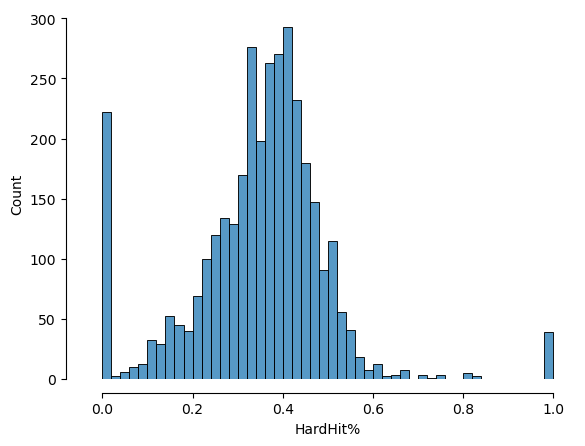

In [4]:
sns.histplot(data=data, x="HardHit%")
sns.despine(offset=10, trim=True);

In the original MARCEL model, Tango dealt with this problem by calculating a weighted average of each player's observed data and the league average. Here, we will use a **hierarchical model** to partially pool the data according to the relative quantity of data for each player-season. Since we are modeling the number of hard hits per batted balls, a binomial sampling distribution with beta-distributed rates is appropriate.

As we were told that the league average hard hit rate is around 35 percent, we can take advantage of the **mean-variance parameterization** of the beta distribution in PyMC:

$$\Large p_i \sim \text{Beta}(\mu=\mu_p, \sigma=\sigma_p)$$

Then, we can assign a weakly-informative priors to $\mu_p$ and $\sigma_p$:

$$\Large \mu_p \sim \text{Beta}(\mu=0.35, \sigma=0.2)$$
$$\Large \sigma_p \sim \text{Uniform}(0, 0.5)$$

In [5]:
with marcel:

    # Empirical rates, regressed to mean with beta-binomial
    mu_p = pm.Beta("mu_p", mu=0.35, sigma=0.2)
    sigma_p = pm.Uniform("sigma_p", 0, 0.5)
    p = pm.Beta("p", mu=mu_p, sigma=sigma_p, dims=("batter", "season"))
    pm.Binomial("rate_like", n=events_x, p=p, observed=hard_hit_x)

The core of the Marcel projection model is the weighted averaging of previous seaons' observations. While the original model hard-coded a 5/4/3 weighting scheme, we will estimate optimal weights from the data. Thus, we are looking to project $p_i^{(t-1)}$ via:

$$\Large p_i^{(t+1)} = w_0 p_i^{(t)} + w_1 p_i^{(t-1)} + w_2 p_i^{(t-2)}$$

where the $p_i$ are the latent partially-pooled rates from above. 

The set of weights $w$, in turn, are modeled with a Dirichlet distribution:

$$\Large \{w_0, w_1, w_2\}\sim \text{Dirichlet}(\phi)$$

A Dirichlet distribution is a generalization of the beta distribution, which is a distribution over a probability simplex of dimension $k$. In our case, $k=3$ and in keeping with the spirit of the original model, we will allocate hyperpriors $\phi = (5, 4, 3)$ as the concentration parameters of the three values.

<!-- For pitcher $i$ having observed values of some quantity of interest in three consecutive years $y_i^{(t)}, y_i^{(t-1)}, y_i^{(t-2)}$ we are predicting $y_i^{(t+1)}$ via:

$$\theta_i^{(t+1)} = \mu_i + w_0 (\theta_i^{(t)}) + w_1 (\theta_i^{(t-1)}) + w_2 (\theta_i^{(t-2)}) + $$

where $\{w_0, w_1, w_2\}\sim \text{Dirichlet}(\phi)$ are constrained to be ordered and the $\theta_i$ are partially pooled observations to regress extreme values. For Gaussian data, the likelihood is:

$$y_i^{(t)} \sim N(\theta_i^{(t)}, \sigma)$$

For other types of data, this likelihood may be binomial or Poisson.



All inputs are automatically standardized to aid in convergence. -->

In [6]:
with marcel:

    # Marcel weights
    w = pm.Dirichlet(
        "w",
        a=np.array([3, 4, 5]),
        dims='season'
    )

    # Raw projection
    p_proj = p @ w


Finally, we implement the aging effect as a simple triangular (piecewise-linear) model on the logit scale, where the hard hit rate increases up to some "peak" age, and then decreases at the same rate thereafter. Both the value of the slope and the peak age are parameters of the model that we can estimate.

$$\Large \alpha_i^{(t+1)} =  \beta (a_0 - a_i^{(t+1)})$$
$$\Large \beta \sim N(0, 1)$$
$$\Large a_0 \sim \text{Uniform}(a_{\min}, a_{\max})$$

In [7]:
with marcel:

    # Coefficient for triangular aging
    beta = pm.Normal("beta")
    # Estimate of peak age
    peak_age = pm.Uniform("peak_age", data.Age.min(), data.Age.max())    

    age_effect = beta * (peak_age - age_y)

So, the projected rate is the age-adjusted weighted average of the latent rates over the three-year period, appropriately transformed to stay on the unit interval. 

Since we are modeling binary events occuring from a fixed number of chances, the binomial distribution is an obvious likelihood function. 

In [8]:

with marcel:
    
    projected_rate = pm.Deterministic(
        "projected_rate",
        pm.math.invlogit(pm.math.logit(p_proj) + age_effect),
        dims="batter"
    )

    # # Likelihood of observed hard hits
    pm.Binomial("prediction", n=events_y, p=projected_rate, observed=hard_hit_y, dims="batter")

    

Before we go ahead and fit the model, let's look at the model graph. It serves as a useful graphical summary of the model, and allows you to verify that you have specified the model correctly. 

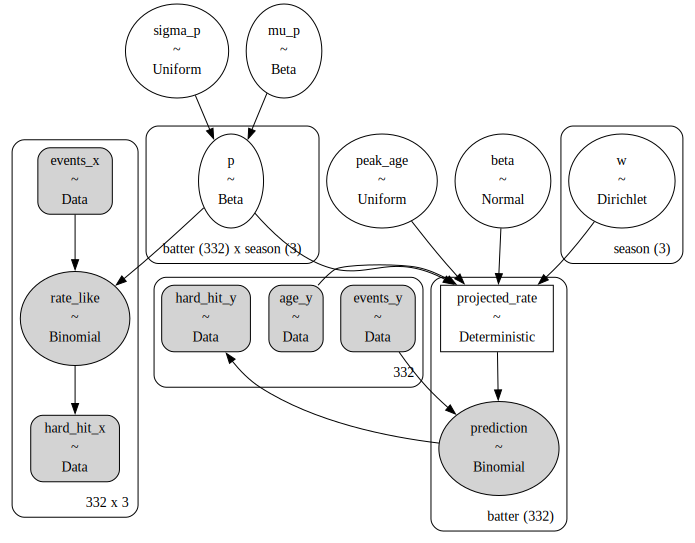

In [10]:
pm.model_to_graphviz(marcel)

![DAG](https://github.com/fonnesbeck/bayesian_marcel/blob/main/assets/dag.png)

We will estimate the model using Markov chain Monte Carlo (MCMC) sampling, specifically the No-U-Turn Sampler (NUTS) algorithm, as implemented in PyMC v5. It should only take a few seconds to sample.

In [9]:
with marcel:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_p, sigma_p, p, w, beta, peak_age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


You want to keep an eye on this output for any warning messages that may require additional intervention in order to improve the model. This example should run fine under the default arguments.

## Model Checking

Even in the absence of warnings, its always important to check your model. In model checking, we want to know at least two things: did the model fitting algorithm work, and does the model fit the data adequately?

For the first part, we want to do **convergence diagnostics** because we have used a stochastic sampling approach (MCMC) to fit the model. That is, we want some assurance that the sampler *converged* to what the model specifies as the posterior distribution. This implies that the algorithm has had a chance to adequately explore the parameter space of the model. 

The `az.plot_energy` function will produce an **energy plot** of the fiitted model that gived a visual indication as to whether the model has been able to freely explore the parameter space. You will see two distributions: a marginal energy distribution and an energy transition distribution. Its not important to understand exactly what these are, but you are looking for these two distribtions to mostly overlap, as they should below. When they do not, the difference is usually rather dramatic. The plot below should be close enough.

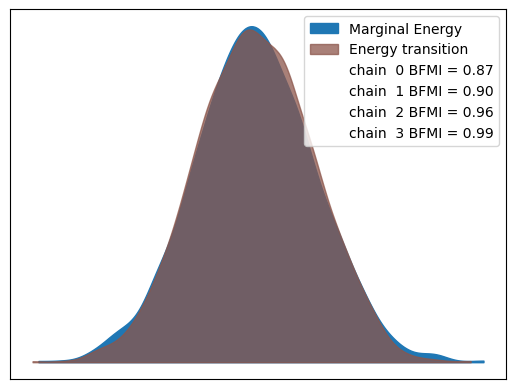

In [10]:
az.plot_energy(trace);

Another useful convergence diagnostic is the **R-hat statistic**, also known as the potential scale reduction factor. It compares the variance of chain means to the mean of chain variances across multiple chains, with values close to 1 indicating good convergence. If R-hat is substantially greater than 1, it suggests that the chains have not yet converged to a common distribution, indicating that more iterations may be needed.

The sampler will return warnings if it detects large R-hat values for any of the parameters, but we can manually check them using the `rhat` function:

In [11]:
az.rhat(trace).max()

<xarray.Dataset> Size: 56B
Dimensions:         ()
Data variables:
    beta            float64 8B 1.001
    mu_p            float64 8B 1.001
    p               float64 8B 1.011
    peak_age        float64 8B 1.002
    projected_rate  float64 8B 1.007
    sigma_p         float64 8B 1.0
    w               float64 8B 1.005

Despite the warning during sampling, these all look fine -- one value is borderline, but nothing to worry about.

If we are satisfied that the model has converged, we can move on to checking the model fit. This is largely the same idea as a model **calibration** check: seeing whether the model predictions correspond adequately to observed values. Since we have a Bayesian model, we can use **posterior predictive checks** for this. This involves generating simulated datasets from the fitted model, and comparing the simulations to the actual observed data (in this case, the data used to fit the model). If the model fits, we would expect the observed data to be indistinguishable from some random draw from the model.

Sampling: [prediction, rate_like]


Output()

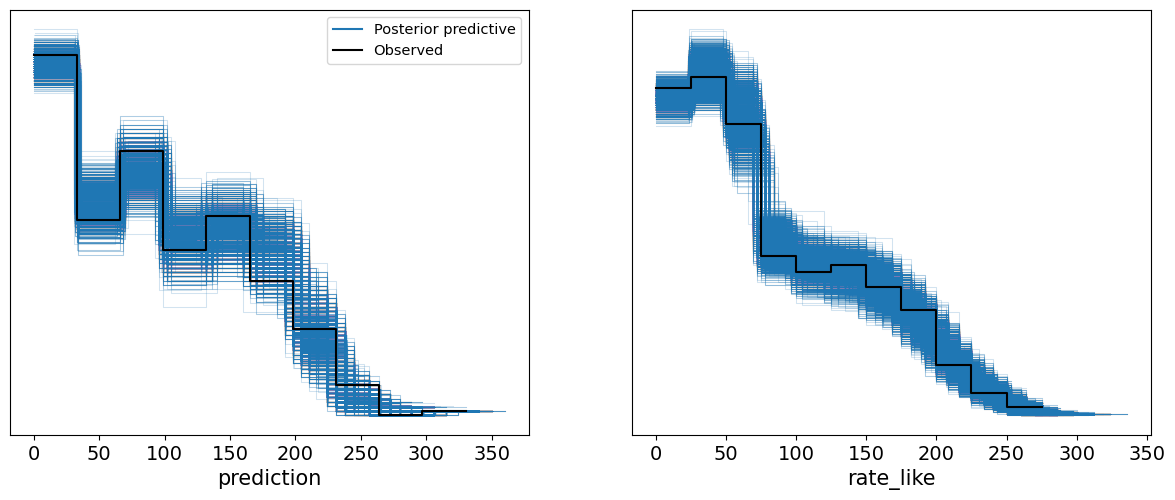

In [12]:
with marcel:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

az.plot_ppc(trace, mean=False);

This doesn't look bad -- the observed data behaves like just another sample from the model.

## Parameter Estimates

Having confirmed the fit of the model, we can move on to looking at some of the latent parameters and seeing if they make sense.

The estimated set of weights decline in magnitude with time, as we would expect. They correspond approximately to a 6/2/1 weighting, which gives the most recent season much more influence relative to the original MARCEL model and its 5/4/3 weighting.

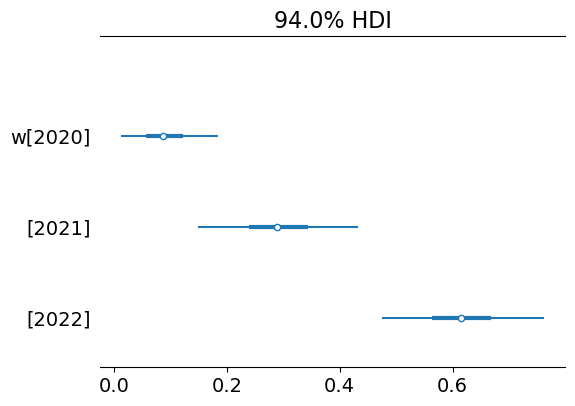

In [13]:
az.plot_forest(trace, var_names='w', combined=True);

From the posterior estimates below, we see that the mean hard hit rate is around 39%. Realistically, this value is probably best regarded as temporally dynamic, but we are resisting the urge to expand the model right now.

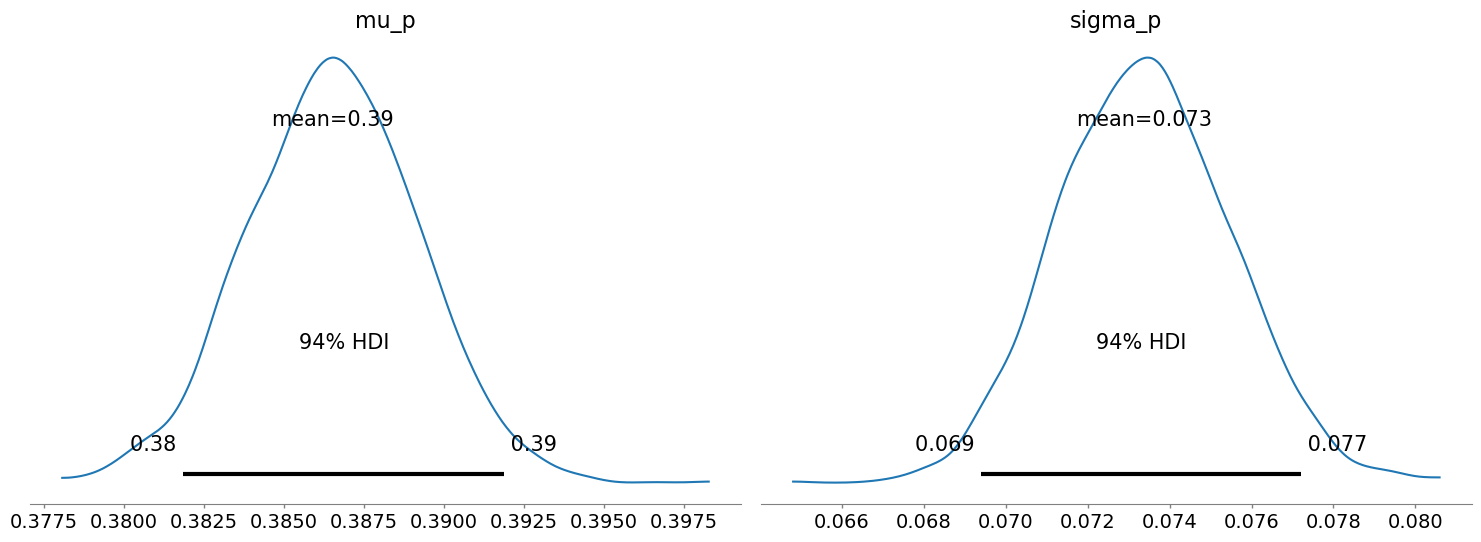

In [14]:
az.plot_posterior(trace, var_names=['mu_p', 'sigma_p'])
plt.tight_layout();

What about the aging effect? The model estimates "peak" hard-hit age to be approximately 28 years (albeit with a wide range of posterior uncertainty), which seems a reasonable inflection point. The corresponding `beta` parameter is positive, indicating a positive slope at ages below 28 and negative above.

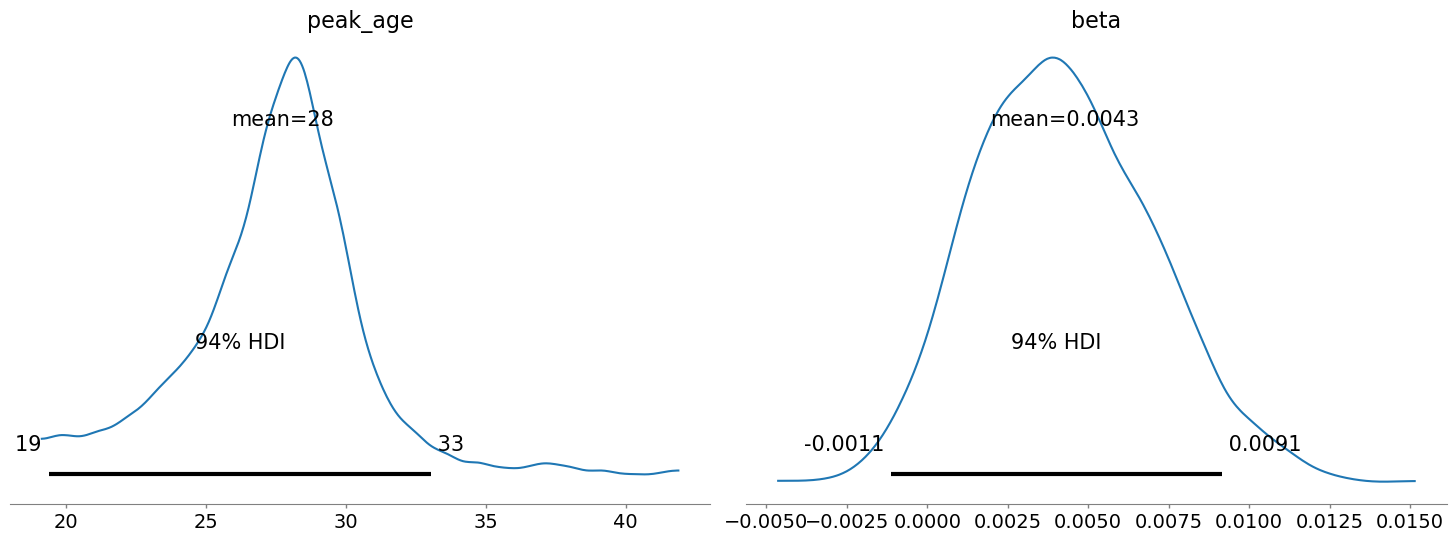

In [15]:
az.plot_posterior(trace, var_names=['peak_age', 'beta'])
plt.tight_layout();

## Generating Projections

Once we have checked the model and are comfortable with the evaluation, we can use it to generate projections for 2024, using input data from 2021 through 2023. Here, we are not estimating anything; we are merely applying the fitted model parameters to a new set of inputs.

In PyMC, the `set_data` function is used to swap in the new data, after which we can use the `sample_posterior_predictive` function to generate predictions. For this model, predictive sampling should be almost instantaneous.

In [16]:
pred_seasons = [2021, 2022, 2023]

with marcel:
    pm.set_data(
        {'age_y': hard_hit_by_season["Age"][2024].to_numpy().astype(np.float32),
         'hard_hit_x': hard_hit_by_season["HardHit"][pred_seasons].to_numpy().astype(np.int32),
         'events_x': hard_hit_by_season["Events"][pred_seasons].to_numpy().astype(np.int32)
        }
    )

    pm.sample_posterior_predictive(trace, var_names=['projected_rate'], predictions=True, extend_inferencedata=True)

Sampling: []


Output()

Let's take a peek and see how the model performs. Below are predictive intervals for each player's expected hard hit rate in 2024, along with the observed rate (which, keep in mind, is only for about a half-season). To help evaluate the predictions, the observed rate is color-coded by sample size -- darker red indicates a larger sample size. 

The model performs well, considering how stripped-down it is. The weighted averaging and partial pooling components have done a nice job of protecting the model from overfitting. The sharing of information via the hierarchical component also means that the predictive intervals are narrow, even for players with relatively sparse data.

If we focus on the players with substantive sample size (*i.e.* those with dark red data points), we can potentially identify hitters that are over- or under-performing. Certainly, Juan Soto, Ketel Marte, and Marcell Ozuna are having great seaons so far, while Whitt Merrifield was released by the Phillies shortly before this writing.

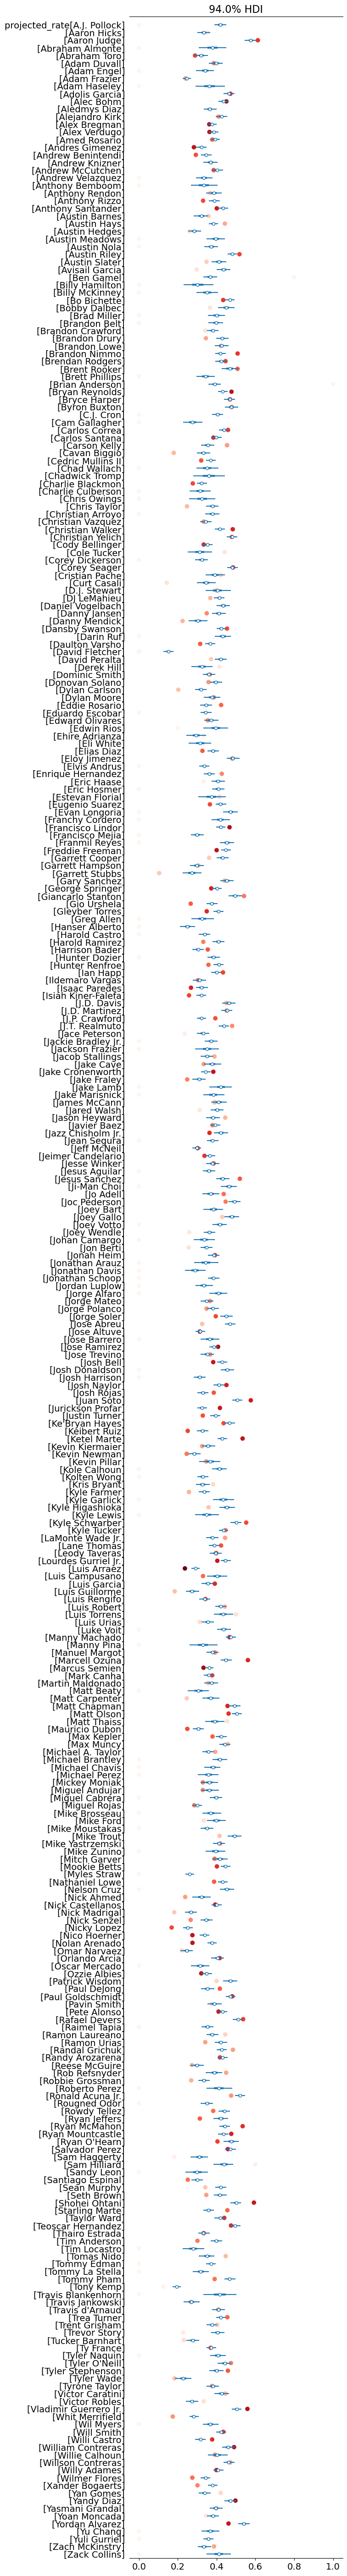

In [17]:
p_obs = (hard_hit_by_season['HardHit'] / hard_hit_by_season['Events'])[2024].fillna(0)

axes = az.plot_forest(trace.predictions['projected_rate'], combined=True, figsize=(6, 72))
axes[0].scatter(p_obs.values[::-1], axes[0].get_yticks(), c=list(hard_hit_by_season.Events[2024].fillna(0).values[::-1]), cmap='Reds');

A scatter plot of projections vs observtions (shaded proportionally to sample size) shows the model to be reasonably well-calibrated.

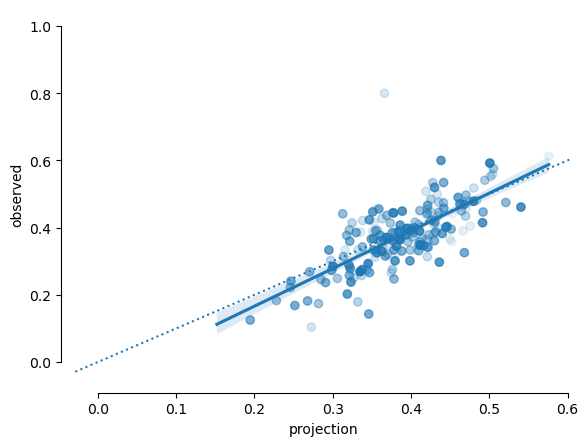

In [18]:
p_proj = trace.predictions['projected_rate'].mean(dim=('chain', 'draw'))
n = hard_hit_by_season["Events"][2024].fillna(0).to_numpy()
p_obs =  hard_hit_by_season["HardHit"][2024].to_numpy() / n

projection = pd.DataFrame(dict(projection=p_proj, observed=p_obs))
ax = sns.regplot(x='projection', y='observed', data=projection, scatter_kws={'alpha':n/n.max()})
ax.axline((0, 0), slope=1, linestyle=":")
sns.despine(ax=ax, offset=10, trim=True);

## When Things Go Wrong

With such a simple model that can be applied to virtually any metric, inevitably things will go wrong with certain datasets. The first place to look for symptoms of a problem are in the warnings during model fitting. For example, you may read something along the lines of:

> UserWarning: Chain 0 contains 6 diverging samples after tuning. Increase `target_accept` or reparameterize.

This means that the model is (occasionally) having trouble sampling from the model, which results in a **diverging** sample. If this happens only a few times (6 is not many!) things are probably okay, but if there are hundreds or even entirely divergent samples, you will not be able to reliably use inference from the model. 

The underlying PyMC model tries to give advice when it can: while you cannot reparameterize this model, it is possible to change the `target_accept` parameter passed to `sample`.  

    pm.sample(target_accept=0.99)

`target_accept` is the target acceptance rate of the MCMC algorithm, which in PyMC is 0.8 by default. For difficult models, upping this value to 0.9, 0.95 or 0.99 can sometimes solve this issue. Note that higher acceptance rates result in longer runtimes, since it involves taking more steps at every iteration of the model.

If you run into issues with convergence, for example if the energy plots do not look slimiar, the easiest remedy is to run the MCMC model longer--specifically, to add more **tuning steps**. The default number is 1000 tuning steps, but you can change this with the `tune` argument.

    pm.sample(tune=5000)

Of course, there will be some scenarios where a super-simple model will just not work. If there are issues with the data, or the data do not conform to a simple statistical likelihood like a binomial, then you may need to build a bespoke model to account for the particular characteristics of the quantity you are trying to project.


## Conclusions

In one sense, the MARCEL model represents the core of almost any viable player projection model: it uses past performance to predict future performance, regresses projections to some population mean, and adjusts for the effects of aging. While I used it here to project hard hit rate via a binomial sampling process, we could just as easily have modeled pitcher fastball velocity with essentially the same model, swapping out the binomial likelhood for a Gaussian. For that matter, it could have been used to project wide receiver sprint speed in football or goalie save percentage in ice hockey.

Re-casting MARCEL in the Bayesian paradigm proved to be a straightforward enhancement that preserved the overall simplicity of the original model. It gave us a natural way of regressing projections to the mean, a principled was of weighting past performance, and a probabilistic measure of uncertainty in our projections. We used the same ingredients for the model, merely implementing them in a different way.

Of course, the Bayesian monkey might not be the best choice for all of your projection needs. Clearly, we've left a lot on the table, and this is by design. It is best to think of MARCEL (Bayesian or otherwise) as a starting point in the development of a performant projection system. With relatively little effort (or additional data), the model could be expanded to account for obvious shortcomings. For example:

- Aging curves for most performance time series are not triangular, as we've assumed here. One might, for example, swap in a quadratic or some other polynomial function, or get fancy and use a spline. 
- Further, there is often age-related **selection bias** at play, whereby older players are not representative of the general population at that age, since only top veterans tend to play into their late thirties and forties. Some type of censoring model can be used to adjust for this.
- Performance can often be influenced by location. With sufficiently large data sets, its possible to estimate **venue effects** that can be used to adjust projections to be venue-neutral. 
- The weighting scheme implemented by MARCEL is essentially third-order autoregressive model. It may be worth considering alternative time series models, depending on the metric in question. For example, there may be processes operating at multiple time scales that may influence performance, in which case Gaussian processes can be effective for describing them.

The workflow for constructing sports projection models is really no different than what we recommend for other types of models. Rather than attempting to build a feature-complete model at the outset, start with a baseline model that is easy to understand and implement, then expand according to how that model falls short relative to the goals of the project. The Bayesian MARCEL provides a reasonable starting point for a baseball projection system, not unlike the ordinary least squares model does for regression problems.

---

## References

- [Tango on Baseball](https://tangotiger.net/marcel/)
- [Baseball-Reference.com](https://www.baseball-reference.com/about/marcels.shtml)


In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Jul 16 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

pymc      : 5.16.1
arviz     : 0.18.0
pandas    : 2.2.2
matplotlib: 3.8.4
seaborn   : 0.13.2
numpy     : 1.26.4

Watermark: 2.4.3

